# Near-Earth Objects Classification using SVM

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
# Read the data from CSV.
nasa_dataset = pd.read_csv('NASA.csv')

### Normalize and remove outliers function

In [3]:
# Normalizing the columns used for fitting models
# Removing outliers using z-score normalization.
from sklearn.preprocessing import StandardScaler;

# Columns used for generating models and predicitons
cols = ['est_diameter_min', 'est_diameter_max', 'miss_distance', 'absolute_magnitude'];

def normalize_and_remove_outliers(df):
    df[cols] = StandardScaler().fit_transform(df[cols]);

    # Removing values with z-score more than 3.32 and less thatn -3.32.
    # This will remove the extremes 0.05% which we are considering as outliers.
    df[cols]= df[(df[cols] <= 3.32)&(df[cols] >= -3.32)][cols];
    return df.dropna();

### Test/Train data split function

In [4]:
# Generating training and test data.
from sklearn.model_selection import train_test_split

def get_train_test_data(X, y):    
    return train_test_split(X, y, test_size=0.20, random_state=42)

### Model fitting and prediction functions

In [5]:
# Fitting the train and testing model in SVM model.
from sklearn.svm import SVC

def fit_model_and_predict(X_train_set, X_test_set, y_train_set, gamma, C):
    svc_model = SVC(gamma=gamma, C=C)

    print("Fitting training set into SVM model")
    svc_model.fit(X_train_set, y_train_set)

    print("SVM Model Trained")
    print("Predicting test data")
    return svc_model, svc_model.predict(X_test_set)

In [6]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]}

def fit_grid_model_and_predict(X_train_set, X_test_set, y_train_set):
    grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
    print("Fitting training set into GridSearchCV model")
    grid.fit(X_train_set, y_train_set)
    
    print("GridSearchCV Model Trained")
    print("Predicting test data")
    return grid, grid.predict(X_test_set)


### Print confusion matrix and report function

In [7]:
# Printing confusion matrix and classification report.
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_test_set, y_predictions):
    ConfusionMatrixDisplay.from_predictions(
        y_test_set,
        y_predictions,
        cmap="Blues"
    )

def print_matrix_and_report(y_test_set, y_predictions):
    plot_confusion_matrix(y_test_set, y_predictions)

    print("Classification Report: ")
    print(classification_report(y_test_set, y_predictions))

### Perform PCA

In [8]:
# Performing PCA and learning the component names
from sklearn.decomposition import PCA

def perform_PCA(X):
    pca = PCA(n_components=2).fit(X)
    X_pc = pca.transform(X)

    # number of components
    number_of_pcas = pca.components_.shape[0]

    # get the index of the most important feature on EACH component
    most_important = [np.abs(pca.components_[i]).argmax() for i in range(number_of_pcas)]
    # get the most_important_columns
    most_important_columns = [cols[most_important[i]] for i in range(number_of_pcas)]
    print("Columns for PCA", most_important_columns);
    
    # Create a dataframe using the component names and components' data.
    return pd.DataFrame(columns=most_important_columns, data=X_pc)

### Generate the CSV

In [9]:
# Generates and saves CSV to a file.
def generate_csv(filename, test, actual_set, predictions_set):
    test_df = pd.DataFrame(test).copy()
    test_df['actual'] = np.array(actual_set).flatten()
    test_df['prediction'] = predictions_set
    
    # This is to generate the relplot    
    actual_columns = np.setdiff1d(test_df.columns, np.array(['actual', 'prediction']))
    if len(actual_columns) == 2:
        sns.relplot(
            x=actual_columns[0],
            y=actual_columns[1],
            data=test_df,
            hue=test_df[['actual', 'prediction']].apply(tuple, axis=1)
        )
    # This is to generate the relplot
    test_df.to_csv(filename, sep='\t', index=False)
    print(filename + " generated in the same folder");

### Generate Decision Boundary

In [10]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def generate_boundary_decision(model, x_test_set, y_test_set):
    h = .02  # step size in the mesh

    x_data = np.array(x_test_set[x_test_set.columns[0]]).flatten()
    y_data = np.array(x_test_set[x_test_set.columns[1]]).flatten()

    # create a mesh to plot in
    x_min, x_max = x_data.min() - 1, x_data.max() + 1
    y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    plt.figure(figsize=(20, 10))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap='binary', alpha=0.6)

    # Plot also the training points
    plt.scatter(x_data, y_data, c=y_test_set, cmap='RdYlGn', marker='+')

## Plotting and curating the dataset

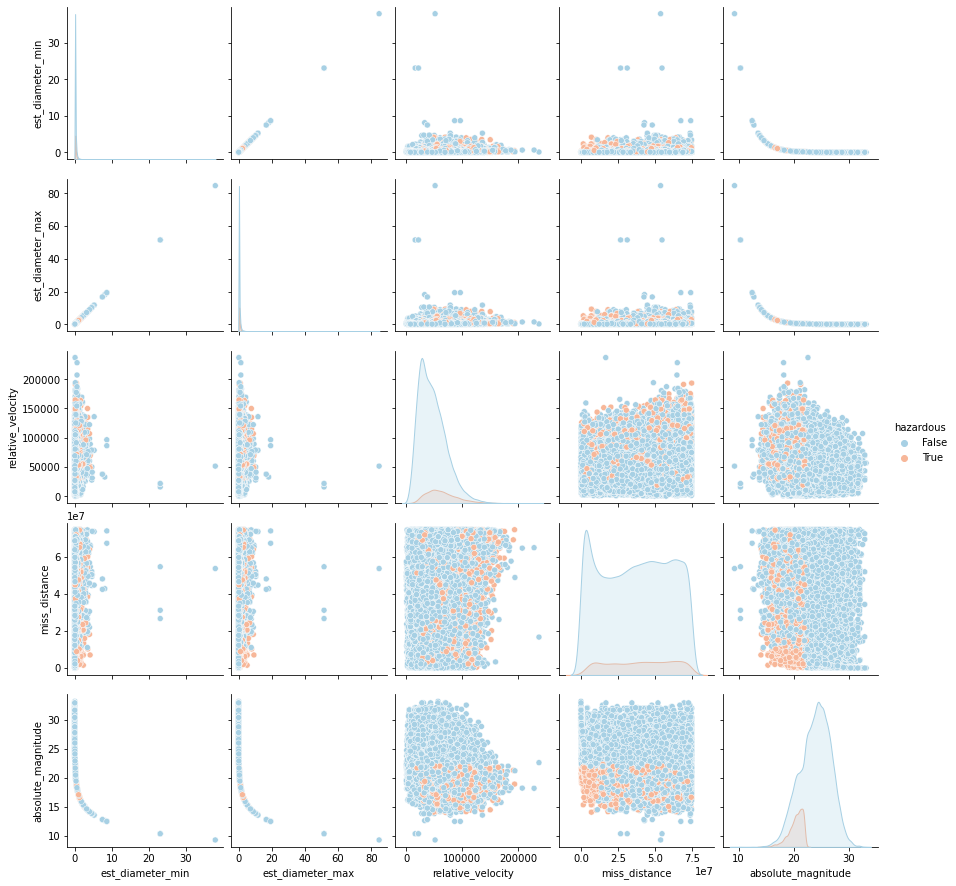

In [11]:
# Plot graphs
nasa_dataset.dropna()

# Check pairplot for data correlation and analysis of outliers
sns.pairplot(
    nasa_dataset,
    vars = ['est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'absolute_magnitude'],
    hue="hazardous",
    palette='RdBu_r'
);

In [12]:
# Remove outliers
nasa_dataset = normalize_and_remove_outliers(nasa_dataset);

<AxesSubplot:xlabel='hazardous', ylabel='count'>

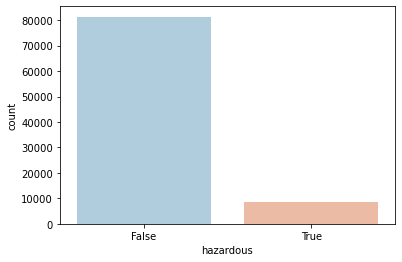

In [13]:
# Count plot nasa dataset which reveals no of of distinct(true/false) hazardous claims
sns.countplot(data=nasa_dataset, x='hazardous', palette='RdBu_r')

## Basic SVM model

### GridSearchCV to generate params

In [14]:
# Generate train and test data
X = nasa_dataset[cols]
y = nasa_dataset['hazardous']

X_train, X_test, y_train, y_test = get_train_test_data(X, y)

print(len(nasa_dataset), len(X_train), len(X_test))

89981 71984 17997


In [15]:
grid_model, grid_search_predicitions = fit_grid_model_and_predict(X_train, X_test, y_train)  

Fitting training set into GridSearchCV model
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time=  17.9s
[CV] END .....................................C=0.1, gamma=1; total time=  17.8s
[CV] END .....................................C=0.1, gamma=1; total time=  17.8s
[CV] END .....................................C=0.1, gamma=1; total time=  17.7s
[CV] END .....................................C=0.1, gamma=1; total time=  18.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=  16.9s
[CV] END ...................................C=0.1, gamma=0.1; total time=  17.2s
[CV] END ...................................C=0.1, gamma=0.1; total time=  16.5s
[CV] END ...................................C=0.1, gamma=0.1; total time=  17.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=  16.9s
[CV] END ..................................C=0.1, gamma=0.01; total time=  14.2s
[CV

Classification Report: 
              precision    recall  f1-score   support

       False       0.92      1.00      0.96     16329
        True       0.85      0.14      0.24      1668

    accuracy                           0.92     17997
   macro avg       0.88      0.57      0.60     17997
weighted avg       0.91      0.92      0.89     17997



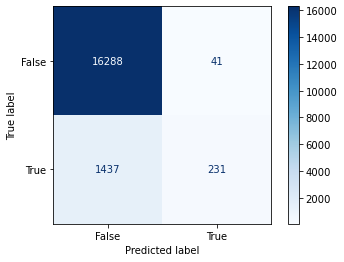

In [16]:
print_matrix_and_report(y_test, grid_search_predicitions)

In [17]:
# Get best gamma and C values
best_params = grid_model.best_params_
print("Best params from grid search cv model: ", best_params)
C = best_params['C']
gamma = best_params['gamma']
print('C: ', C)
print('Gamma: ', gamma)

Best params from grid search cv model:  {'C': 100, 'gamma': 1}
C:  100
Gamma:  1


### SVC using best params from GridSearchCV

In [18]:
svc_model, predictions = fit_model_and_predict(X_train, X_test, y_train, gamma, C)

Fitting training set into SVM model
SVM Model Trained
Predicting test data


Classification Report: 
              precision    recall  f1-score   support

       False       0.92      1.00      0.96     16329
        True       0.85      0.14      0.24      1668

    accuracy                           0.92     17997
   macro avg       0.88      0.57      0.60     17997
weighted avg       0.91      0.92      0.89     17997



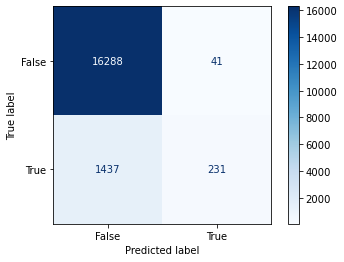

In [19]:
print_matrix_and_report(y_test, predictions)

## SVM model after PCA

In [20]:
pca_X = perform_PCA(X)

Columns for PCA ['absolute_magnitude', 'miss_distance']


### GridSearchCV to generate params

In [21]:
pca_X_train, pca_X_test, pca_y_train, pca_y_test = get_train_test_data(pca_X, y)

print(len(nasa_dataset), len(pca_X_train), len(pca_X_test))

89981 71984 17997


In [22]:
pca_grid_model, grid_search_pca_predicitions = fit_grid_model_and_predict(pca_X_train, pca_X_test, pca_y_train)

Fitting training set into GridSearchCV model
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time=  17.0s
[CV] END .....................................C=0.1, gamma=1; total time=  17.0s
[CV] END .....................................C=0.1, gamma=1; total time=  16.9s
[CV] END .....................................C=0.1, gamma=1; total time=  16.9s
[CV] END .....................................C=0.1, gamma=1; total time=  17.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=  16.4s
[CV] END ...................................C=0.1, gamma=0.1; total time=  16.7s
[CV] END ...................................C=0.1, gamma=0.1; total time=  16.3s
[CV] END ...................................C=0.1, gamma=0.1; total time=  16.6s
[CV] END ...................................C=0.1, gamma=0.1; total time=  16.5s
[CV] END ..................................C=0.1, gamma=0.01; total time=  13.0s
[CV

Classification Report: 
              precision    recall  f1-score   support

       False       0.92      1.00      0.96     16329
        True       0.85      0.14      0.24      1668

    accuracy                           0.92     17997
   macro avg       0.88      0.57      0.60     17997
weighted avg       0.91      0.92      0.89     17997



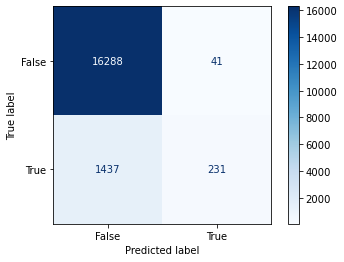

In [23]:
print_matrix_and_report(pca_y_test, grid_search_pca_predicitions)

In [24]:
# Get best gamma and C values
pca_best_params = pca_grid_model.best_params_
print("Best params from grid search cv model after PCA: ", best_params)
pca_C = pca_best_params['C']
pca_gamma = pca_best_params['gamma']
print('After PCA, C: ', pca_C)
print('After PCA, Gamma: ', gamma)

Best params from grid search cv model after PCA:  {'C': 100, 'gamma': 1}
After PCA, C:  100
After PCA, Gamma:  1


### SVC using best params from GridSearchCV

In [25]:
pca_svc_model, pca_predictions = fit_model_and_predict(pca_X_train, pca_X_test, pca_y_train, pca_gamma, pca_C)

Fitting training set into SVM model
SVM Model Trained
Predicting test data


Classification Report: 
              precision    recall  f1-score   support

       False       0.92      1.00      0.96     16329
        True       0.85      0.14      0.24      1668

    accuracy                           0.92     17997
   macro avg       0.88      0.57      0.60     17997
weighted avg       0.91      0.92      0.89     17997



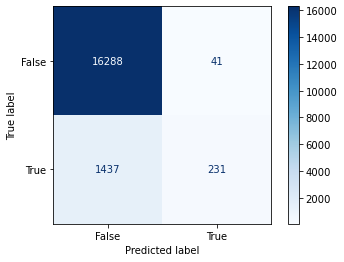

In [26]:
print_matrix_and_report(pca_y_test, pca_predictions)

### Plot boundary and generate CSVs

PCA_SVM_test_predictions.csv generated in the same folder


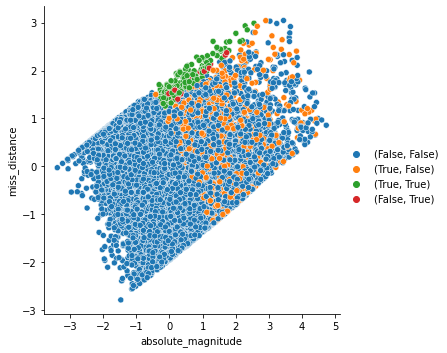

In [27]:
generate_csv('PCA_SVM_test_predictions.csv', pca_X_test, pca_y_test, pca_predictions)

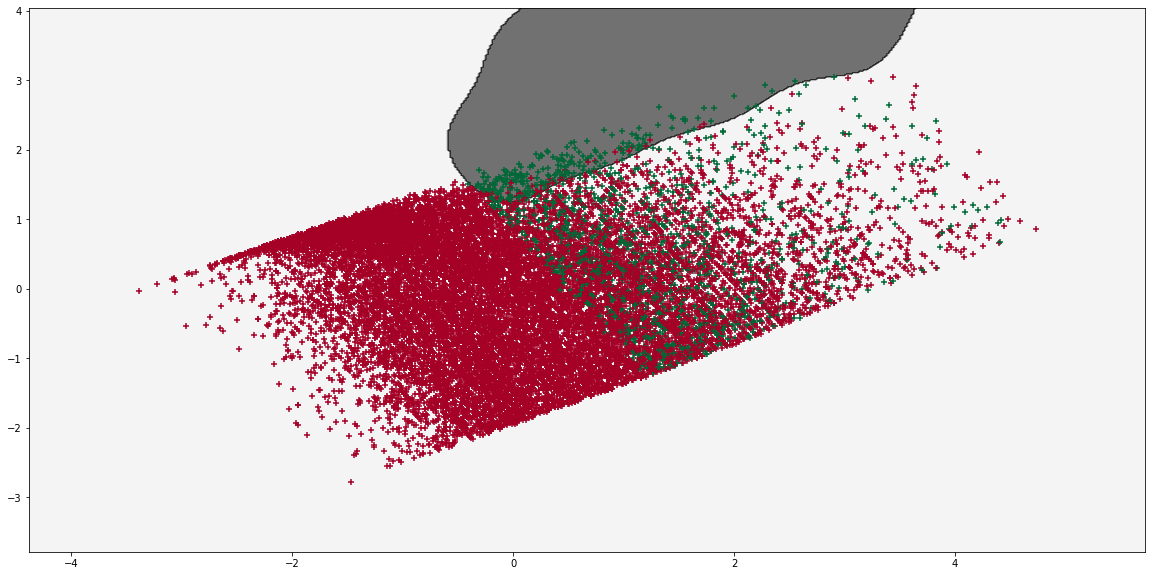

In [28]:
generate_boundary_decision(pca_svc_model, pca_X_test, pca_y_test)

In [29]:
generate_csv('SVM_test_predictions.csv', X_test, y_test, predictions)

SVM_test_predictions.csv generated in the same folder


## Downsample non-hazardous near earth objects

In [30]:
from sklearn.utils import resample

true_sample = nasa_dataset[nasa_dataset['hazardous'] == True].copy()
false_sample = nasa_dataset[nasa_dataset['hazardous'] == False].copy()

false_downsample = resample(
    nasa_dataset,
    replace=True,
    n_samples=len(true_sample),
    random_state=42
)

d_sample = pd.concat([true_sample, false_downsample])

d_X = d_sample[cols]
d_y = d_sample['hazardous']

### Basic SVM model

Fitting training set into SVM model
SVM Model Trained
Predicting test data
Classification Report: 
              precision    recall  f1-score   support

       False       0.99      0.75      0.86      1567
        True       0.83      1.00      0.90      1879

    accuracy                           0.89      3446
   macro avg       0.91      0.87      0.88      3446
weighted avg       0.90      0.89      0.88      3446



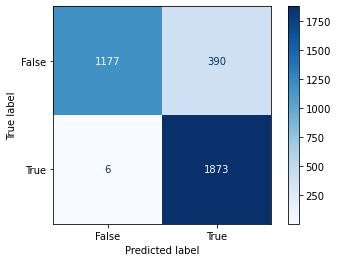

In [31]:
d_X_train, d_X_test, d_y_train, d_y_test = get_train_test_data(d_X, d_y)
d_model, d_predictions = fit_model_and_predict(d_X_train, d_X_test, d_y_train, gamma, C)
print_matrix_and_report(d_y_test, d_predictions)

### SVM model after PCA

Columns for PCA ['absolute_magnitude', 'miss_distance']
Fitting training set into SVM model
SVM Model Trained
Predicting test data
Classification Report: 
              precision    recall  f1-score   support

       False       1.00      0.75      0.86      1567
        True       0.83      1.00      0.90      1879

    accuracy                           0.89      3446
   macro avg       0.91      0.87      0.88      3446
weighted avg       0.90      0.89      0.88      3446



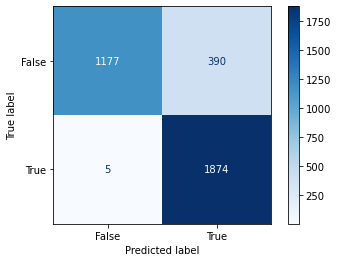

In [32]:
d_pca_X = perform_PCA(d_X)
d_pca_X_train, d_pca_X_test, d_pca_y_train, d_pca_y_test = get_train_test_data(d_pca_X, d_y)
d_pca_svc_model, d_pca_predictions = fit_model_and_predict(d_pca_X_train, d_pca_X_test, d_pca_y_train, pca_gamma, pca_C)
print_matrix_and_report(d_pca_y_test, d_pca_predictions)

### Plot boundary and generate CSVs

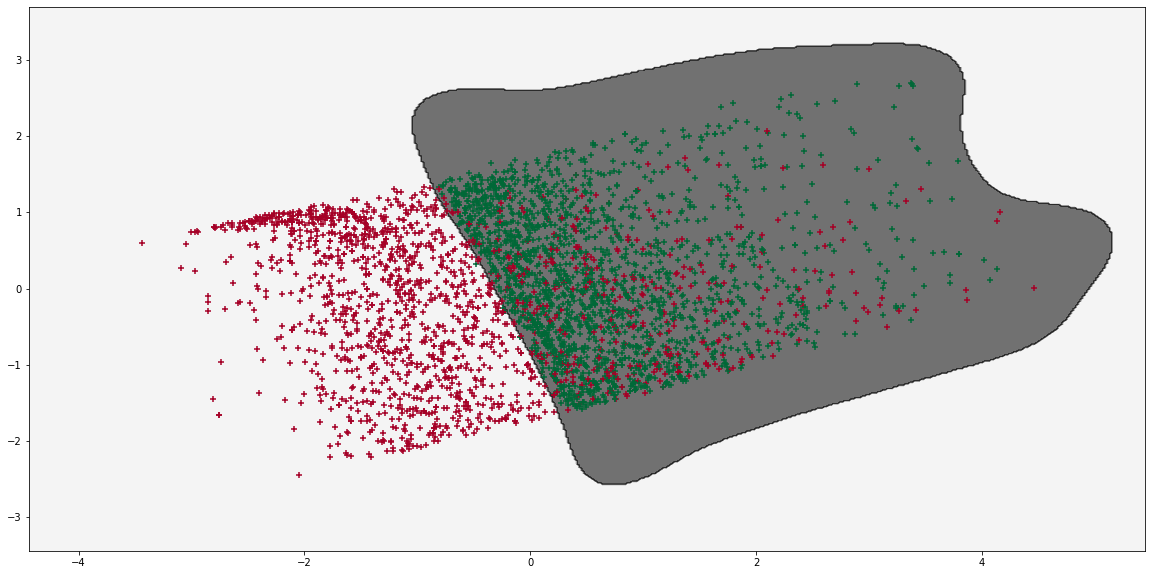

In [33]:
generate_boundary_decision(d_pca_svc_model, d_pca_X_test, d_pca_y_test)

Downscaled_PCA_SVM_test_predictions.csv generated in the same folder


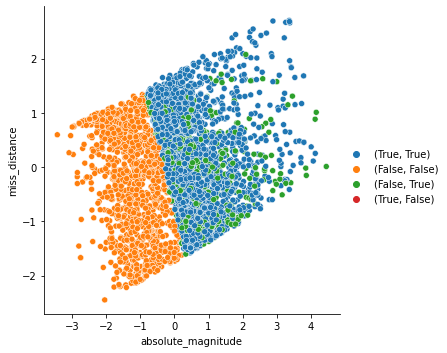

In [34]:
generate_csv('Downscaled_PCA_SVM_test_predictions.csv', d_pca_X_test, d_pca_y_test, d_pca_predictions)

In [35]:
generate_csv('Downscaled_SVM_test_predictions.csv', d_X_test, d_y_test, d_predictions, )

Downscaled_SVM_test_predictions.csv generated in the same folder
